# Energetic Forecast with Prophet

In [1]:
# basic functionalities
import datetime
import itertools

# data transforamtion and manipulation
import pandas as pd
import numpy as np
import pandas_profiling

# remove warnings
import warnings
warnings.filterwarnings('ignore')

# plotting and plot styling
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Prophet modeling libaries
from prophet import Prophet
# metrics 
from random import random
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error 
from sklearn.metrics import median_absolute_error, mean_squared_log_error

# Importing data
- Dataset: Electricity consumption in the state of PMJ
- Unit: Mega Watt: MW
- Hourly timestamp 
 

<img src="https://frenzy86.s3.eu-west-2.amazonaws.com/IFAO/energy_cons.png" width="1000">

In [2]:
!wget https://frenzy86.s3.eu-west-2.amazonaws.com/IFAO/PJME_hourly.csv

--2022-12-01 17:21:28--  https://frenzy86.s3.eu-west-2.amazonaws.com/IFAO/PJME_hourly.csv
Resolving frenzy86.s3.eu-west-2.amazonaws.com (frenzy86.s3.eu-west-2.amazonaws.com)... 52.95.150.190
Connecting to frenzy86.s3.eu-west-2.amazonaws.com (frenzy86.s3.eu-west-2.amazonaws.com)|52.95.150.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4070265 (3.9M) [text/csv]
Saving to: ‘PJME_hourly.csv’

PJME_hourly.csv     100%[===================>]   3.88M  4.09MB/s    in 0.9s    

2022-12-01 17:21:29 (4.09 MB/s) - ‘PJME_hourly.csv’ saved [4070265/4070265]



In [3]:
df = pd.read_csv('PJME_hourly.csv')
df

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0
...,...,...
145361,2018-01-01 20:00:00,44284.0
145362,2018-01-01 21:00:00,43751.0
145363,2018-01-01 22:00:00,42402.0
145364,2018-01-01 23:00:00,40164.0


## __Converting to datetime format and sort:__

In [4]:
# convert: 
df['Datetime'] = pd.to_datetime(df['Datetime'])
# sort:
df.sort_values(by=['Datetime'], axis=0, ascending=True, inplace=True)

# renaming the target variable columns
df.rename(columns={'PJME_MW':'Consumption [MW]'}, inplace=True)
df

,Datetime,Consumption [MW]
8734,2002-01-01 01:00:00,30393.0
8735,2002-01-01 02:00:00,29265.0
8736,2002-01-01 03:00:00,28357.0
8737,2002-01-01 04:00:00,27899.0
8738,2002-01-01 05:00:00,28057.0
...,...,...
140250,2018-08-02 20:00:00,44057.0
140251,2018-08-02 21:00:00,43256.0
140252,2018-08-02 22:00:00,41552.0
140253,2018-08-02 23:00:00,38500.0


## __Removal duplicates__:

In [5]:
#keep only the last measurement for datetime
df.drop_duplicates(subset='Datetime', keep='last', inplace=True)

## __Setting index as the datetime column for easier manipulations:__

In [6]:
df = df.set_index('Datetime')
df

,Consumption [MW]
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0
...,...
2018-08-02 20:00:00,44057.0
2018-08-02 21:00:00,43256.0
2018-08-02 22:00:00,41552.0


__Note:__
- datetime index's frequency is None => there are some missing data points somewhere (otherwise Python could deduce it) => remove missing 

## __Find and Fill Missing datetime Instances__

In [7]:
# ideal range: without missing data
date_range = pd.date_range(start=min(df.index), end=max(df.index), freq='H')

In [8]:
#Reindex the dataset and then fill data:

#Create null values in missing data:
df = df.reindex(date_range)

#Filling  missing  with linear interpolation between existing data points
df['Consumption [MW]'].interpolate(method='linear', inplace=True)

# now we have a neatly continuous datetime index
print(f'The df.index.freq is now: {df.index.freq}, => we no have missing instances')


The df.index.freq is now: <Hour>, => we no have missing instances


## Extracting Time Features

- We split datetime into its different __features__ => to find patterns for different groups.

In [9]:
df['dayofweek'] = df.index.dayofweek
df['dayofyear'] = df.index.dayofyear
df['year'] = df.index.year
df['month'] = df.index.month
df['quarter'] = df.index.quarter
df['hour'] = df.index.hour
df['weekday'] = df.index.weekday
df['weekofyear'] = df.index.weekofyear
df['dayofmonth'] = df.index.day # Day of Month
df['date'] = df.index.date 

# let's add the season number
df['season'] = df['month'].apply(lambda month_number: (month_number%12 + 3)//3)

In [ ]:
df

,Consumption [MW],dayofweek,dayofyear,year,month,quarter,hour,weekday,weekofyear,dayofmonth,date,season
2002-01-01 01:00:00,30393.0,1,1,2002,1,1,1,1,1,1,2002-01-01,1
2002-01-01 02:00:00,29265.0,1,1,2002,1,1,2,1,1,1,2002-01-01,1
2002-01-01 03:00:00,28357.0,1,1,2002,1,1,3,1,1,1,2002-01-01,1
2002-01-01 04:00:00,27899.0,1,1,2002,1,1,4,1,1,1,2002-01-01,1
2002-01-01 05:00:00,28057.0,1,1,2002,1,1,5,1,1,1,2002-01-01,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,3,214,2018,8,3,20,3,31,2,2018-08-02,3
2018-08-02 21:00:00,43256.0,3,214,2018,8,3,21,3,31,2,2018-08-02,3
2018-08-02 22:00:00,41552.0,3,214,2018,8,3,22,3,31,2,2018-08-02,3
2018-08-02 23:00:00,38500.0,3,214,2018,8,3,23,3,31,2,2018-08-02,3


## Forecasting metrics


In [10]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def evaluate_forecast(y_true,y_pred):
    results = pd.DataFrame({'r2_score':r2_score(y_true-np.median(y_true), y_pred-np.median(y_pred))}, 
                           index=[0])
    results['mean_absolute_error'] = mean_absolute_error(y_true, y_pred)
    results['median_absolute_error'] = median_absolute_error(y_true, y_pred)
    results['mse'] = mean_squared_error(y_true, y_pred)
    results['msle'] = mean_squared_log_error(y_true, y_pred)
    results['mape'] = mean_absolute_percentage_error(y_true, y_pred)
    results['rmse'] = np.sqrt(results['mse'])
    return results

# Long Term Forecasting

## Train and Test split

In [11]:
y    = df['Consumption [MW]']
df.index.min(),df.index.max()

(Timestamp('2002-01-01 01:00:00', freq='H'),
 Timestamp('2018-08-03 00:00:00', freq='H'))

In [12]:
t_train_start = '2013-01-01'
t_train_end   = '2016-12-31'
 
# splitting
y_train = y.loc[(y.index >= t_train_start) & (y.index <= t_train_end)].copy()
y_test  = y.loc[(y.index >  t_train_end)].copy()
y       = y_train.append(y_test) 


In [ ]:
y_train.index.min(), y_train.index.max(), y_test.index.min(), y_test.index.max(),

(Timestamp('2013-01-01 00:00:00', freq='H'),
 Timestamp('2016-12-31 00:00:00', freq='H'),
 Timestamp('2016-12-31 01:00:00', freq='H'),
 Timestamp('2018-08-03 00:00:00', freq='H'))

In [13]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_train.index, y=y_train,
                         mode='lines',
                         name='Train'))

fig.add_trace(go.Scatter(x=y_test.index, y=y_test,
                         mode='lines', 
                         name='Test'))

# adjust layout
fig.update_layout(title='Train/Test Split',
                  xaxis_title='Date & Time (yyyy/mm/dd hh:MM)',
                  yaxis_title='Energy Demand [MW]')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(count=2, label="3y", step="year", stepmode="backward"),
            dict(count=3, label="5y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)

## The Prophet Forecasting Model

Prophet was developed by Facebook and released as open source in 2017: [https://facebook.github.io/prophet/]

The library utilizes the [additive regression model](https://en.wikipedia.org/wiki/Additive_model) $y(t)$ comprising the following components:

$$y(t) = g(t) + s(t) + h(t) + \epsilon(t)$$

where:
* Trend $g(t)$ models non-periodic changes : __piecewise linear__ or __logistic growth__ curve for modelling non-periodic changes in time series
* Seasonality $s(t)$ represents periodic changes (e.g. weekly/yearly seasonality)
* Holidays component $h(t)$ contributes information about holidays and events effects of holidays (user provided) with irregular schedules.

 
### Trend

The Prophet library implements two possible trend models for $g(t)$.

- *Nonlinear, Saturating Growth*. It is represented in the form of the [logistic growth model](https://en.wikipedia.org/wiki/Logistic_function):

$$g(t) = \frac{C}{1+e^{-k(t - m)}},$$

- *Piecewise Linear Model* with a constant rate of growth. It is best suited for problems without saturating growth.

### Seasonality

The seasonal component $s(t)$ provides a flexible model of periodic changes due to daily weekly and yearly seasonality. Prophet relies on Fourier series to model seasonality:
* A **higher order** fits the sine wave more closely to the seasonality in the data, at the risk of capturing too much of the noise __overfitting__
* A **lower order** smoothes out the noise, at the risk of not capturing enough of the seasonality __underfitting__

A good, general fit lies in between: try to find this by Prophet's built-in cross-validation method.
 
 

### Holidays and Events

The component $h(t)$ represents predictable abnormal days of the year including those on irregular schedules, e.g., Black Fridays.


### Error

The error term $\epsilon(t)$ represents information that was not reflected in the model. Usually it is modeled as normally distributed noise.






In [14]:
# format data for prophet model using 'ds' and 'y'
train_prophet = pd.DataFrame(y_train).reset_index().rename(columns={
                                                                     'index':'ds', 
                                                                     'Consumption [MW]':'y'
                                                                   })

test_prophet = pd.DataFrame(y_test).reset_index().rename(columns={
                                                                   'index':'ds', 
                                                                   'Consumption [MW]':'y'
                                                                 })


In [15]:
train_prophet.head()

,ds,y
0,2013-01-01 00:00:00,29864.0
1,2013-01-01 01:00:00,28386.0
2,2013-01-01 02:00:00,27250.0
3,2013-01-01 03:00:00,26252.0
4,2013-01-01 04:00:00,25755.0


In [16]:
test_prophet.head()

,ds,y
0,2016-12-31 01:00:00,29627.0
1,2016-12-31 02:00:00,28744.0
2,2016-12-31 03:00:00,28274.0
3,2016-12-31 04:00:00,28162.0
4,2016-12-31 05:00:00,28434.0


In [17]:
# instantiating the class with custom settings, for the sake of illustration
model = Prophet( daily_seasonality  = True,
                   weekly_seasonality = True,
                   yearly_seasonality = True,
                   seasonality_mode   ='additive',
                 )

# fitting the model
model.fit(train_prophet);

# drop y: is part of the dataframe on which we want to make predictions
future = test_prophet.drop(['y'], axis=1)

# predicting values
forecast = model.predict(future)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7tl447sa/w9unoszm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7tl447sa/hn_o62lf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34013', 'data', 'file=/tmp/tmp7tl447sa/w9unoszm.json', 'init=/tmp/tmp7tl447sa/hn_o62lf.json', 'output', 'file=/tmp/tmp7tl447sa/prophet_model4t38rtyy/prophet_model-20221201172717.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:27:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:28:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [18]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-12-31 01:00:00,32779.730256,22590.947230,32047.905084,32779.730256,32779.730256,-5462.840797,-5462.840797,-5462.840797,-4137.065113,...,-515.049590,-515.049590,-515.049590,-810.726095,-810.726095,-810.726095,0.0,0.0,0.0,27316.889459
1,2016-12-31 02:00:00,32780.098263,21399.776911,30424.959165,32780.098263,32780.098263,-6960.471959,-6960.471959,-6960.471959,-5525.979502,...,-630.425808,-630.425808,-630.425808,-804.066648,-804.066648,-804.066648,0.0,0.0,0.0,25819.626304
2,2016-12-31 03:00:00,32780.466270,20668.459382,29426.336965,32780.466270,32780.466270,-7877.811424,-7877.811424,-7877.811424,-6331.019928,...,-749.415807,-749.415807,-749.415807,-797.375689,-797.375689,-797.375689,0.0,0.0,0.0,24902.654846
3,2016-12-31 04:00:00,32780.834277,20320.864168,29407.824744,32780.834277,32780.834277,-8088.089741,-8088.089741,-8088.089741,-6425.913885,...,-871.522534,-871.522534,-871.522534,-790.653322,-790.653322,-790.653322,0.0,0.0,0.0,24692.744536
4,2016-12-31 05:00:00,32781.202284,20332.464751,29955.080223,32781.202284,32781.202284,-7497.045923,-7497.045923,-7497.045923,-5716.945393,...,-996.200873,-996.200873,-996.200873,-783.899657,-783.899657,-783.899657,0.0,0.0,0.0,25284.156361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13915,2018-08-02 20:00:00,37900.546815,-1467.274913,91082.473368,-11344.392054,79964.181838,10784.255650,10784.255650,10784.255650,4368.952376,...,841.211108,841.211108,841.211108,5574.092167,5574.092167,5574.092167,0.0,0.0,0.0,48684.802466
13916,2018-08-02 21:00:00,37900.914822,-2085.329199,89741.712820,-11345.481421,79966.743717,9943.361399,9943.361399,9943.361399,3543.903406,...,833.421274,833.421274,833.421274,5566.036718,5566.036718,5566.036718,0.0,0.0,0.0,47844.276221
13917,2018-08-02 22:00:00,37901.282829,-3391.902399,89448.376307,-11346.570788,79969.305597,8322.490788,8322.490788,8322.490788,1938.971268,...,825.504953,825.504953,825.504953,5558.014567,5558.014567,5558.014567,0.0,0.0,0.0,46223.773617
13918,2018-08-02 23:00:00,37901.650836,-6053.165871,87784.580627,-11347.660155,79971.867476,6224.249543,6224.249543,6224.249543,-142.985595,...,817.209158,817.209158,817.209158,5550.025980,5550.025980,5550.025980,0.0,0.0,0.0,44125.900379


In [19]:
print('Prophet Additive Model:')
ef=evaluate_forecast(test_prophet.y, forecast.yhat)
ef

Prophet Additive Model:


,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.436745,5363.330832,4950.500269,4.033381e+07,0.037571,18.264733,6350.8908


In [20]:
fig = go.Figure()

# draw confidence bound (gray)
fig.add_trace(go.Scatter(x=forecast.ds, 
                         y=forecast.yhat_lower,
                         fill=None,
                         mode='lines',
                         name='Upper CI',
                         line_color='lightpink',
                        ))
fig.add_trace(go.Scatter(
                        x=forecast.ds, 
                        y=forecast.yhat_upper,
                        fill='tonexty', # fill area between trace0 and trace1
                        mode='lines', 
                        name='Lower CI',
                        line_color='lightpink'
                        ))

fig.add_trace(go.Scatter(x=train_prophet.ds, 
                         y=train_prophet.y,
                         mode='lines',
                         name='Train',
                         line_color='blue',
                        ))

fig.add_trace(go.Scatter(x=test_prophet.ds, 
                         y=test_prophet.y,
                         mode='lines',
                         name='Test',
                         line_color='blue',
                        ))

fig.add_trace(go.Scatter(x=forecast.ds, 
                         y=forecast.yhat,
                         mode='lines',
                         name='Forecast',
                         line_color='red',
                        ))


# adjust layout
fig.update_layout(title=f'Prophet Forecast of Hours of Energy Demand:  MAPE=%2.3f%%'%ef['mape'],
                  xaxis_title='Date & Time (yyyy/mm/dd hh:MM)',
                  yaxis_title='Energy Demand [MW]')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(count=2, label="3y", step="year", stepmode="backward"),
            dict(count=3, label="5y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)

Output hidden; open in https://colab.research.google.com to view.

In [21]:
# format data for prophet model using 'ds' and 'y'
train_test_prophet = pd.DataFrame(y).reset_index().rename(columns={
                                                                     'index':'ds', 
                                                                     'Consumption [MW]':'y'
                                                                   })
# predicting training and test values
train_test_forecast = model.predict(train_test_prophet)
train_test_forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-01 00:00:00,31349.381378,24897.971699,34451.800050,31349.381378,31349.381378,-1684.592306,-1684.592306,-1684.592306,-2280.431081,...,1245.625148,1245.625148,1245.625148,-649.786373,-649.786373,-649.786373,0.0,0.0,0.0,29664.789072
1,2013-01-01 01:00:00,31349.722170,23186.058603,32253.018871,31349.722170,31349.722170,-3505.661777,-3505.661777,-3505.661777,-4137.065113,...,1273.834716,1273.834716,1273.834716,-642.431380,-642.431380,-642.431380,0.0,0.0,0.0,27844.060393
2,2013-01-01 02:00:00,31350.062962,21927.553158,30990.255800,31350.062962,31350.062962,-4863.652452,-4863.652452,-4863.652452,-5525.979503,...,1297.374698,1297.374698,1297.374698,-635.047647,-635.047647,-635.047647,0.0,0.0,0.0,26486.410510
3,2013-01-01 03:00:00,31350.403753,21371.608417,30356.996388,31350.403753,31350.403753,-5642.058791,-5642.058791,-5642.058791,-6331.019928,...,1316.596446,1316.596446,1316.596446,-627.635309,-627.635309,-627.635309,0.0,0.0,0.0,25708.344963
4,2013-01-01 04:00:00,31350.744545,20843.262084,30265.896638,31350.744545,31350.744545,-5714.244808,-5714.244808,-5714.244808,-6425.913885,...,1331.863577,1331.863577,1331.863577,-620.194501,-620.194501,-620.194501,0.0,0.0,0.0,25636.499737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48956,2018-08-02 20:00:00,37900.546815,-189.046825,94306.162060,-9437.023099,83363.323154,10784.255650,10784.255650,10784.255650,4368.952376,...,841.211108,841.211108,841.211108,5574.092167,5574.092167,5574.092167,0.0,0.0,0.0,48684.802466
48957,2018-08-02 21:00:00,37900.914822,864.213991,95736.930455,-9444.460815,83368.671949,9943.361399,9943.361399,9943.361399,3543.903406,...,833.421274,833.421274,833.421274,5566.036718,5566.036718,5566.036718,0.0,0.0,0.0,47844.276221
48958,2018-08-02 22:00:00,37901.282829,-811.550272,91567.844995,-9451.898532,83374.020744,8322.490788,8322.490788,8322.490788,1938.971268,...,825.504953,825.504953,825.504953,5558.014567,5558.014567,5558.014567,0.0,0.0,0.0,46223.773617
48959,2018-08-02 23:00:00,37901.650836,-3969.889820,89843.256721,-9459.336249,83379.369539,6224.249543,6224.249543,6224.249543,-142.985595,...,817.209158,817.209158,817.209158,5550.025980,5550.025980,5550.025980,0.0,0.0,0.0,44125.900379


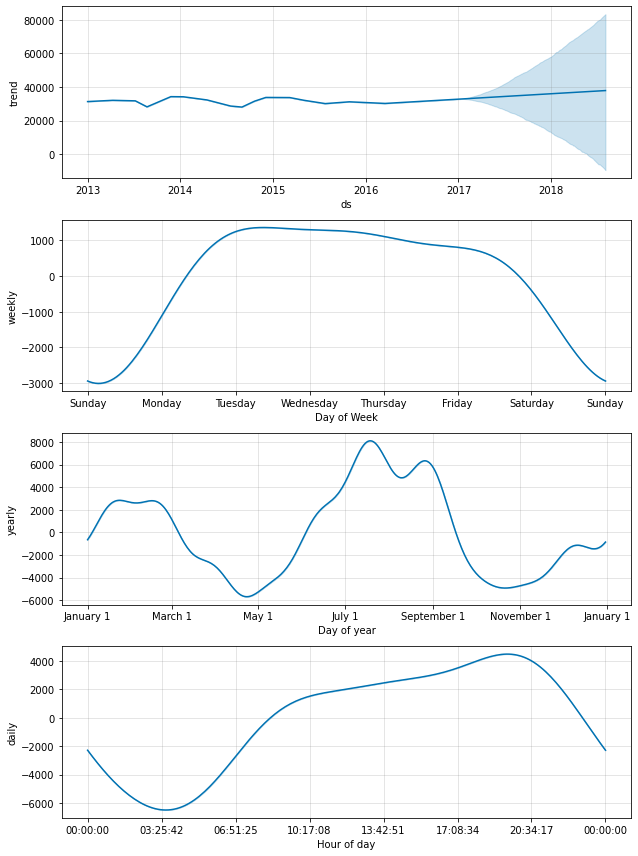

In [24]:
fig = model.plot_components(train_test_forecast);
fig

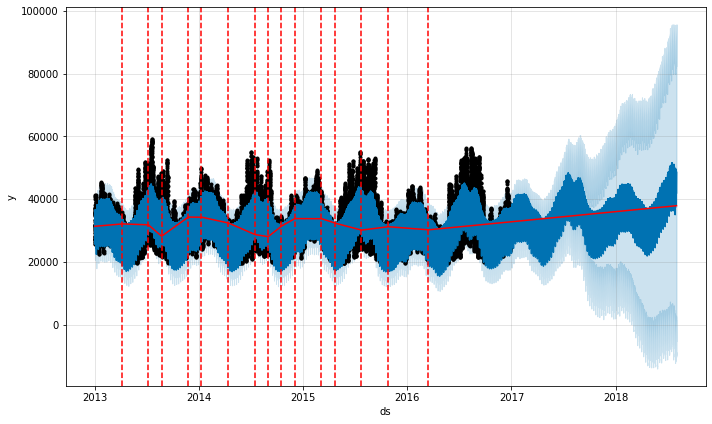

In [26]:
from prophet.plot import add_changepoints_to_plot
fig = model.plot(train_test_forecast);
add_changepoints_to_plot(fig.gca(), model, train_test_forecast);
fig

## CONCLUSIONI

- __DAY feature:__ Energy consumption dipende dalle giornate lavorativi e dai week-end
- __HOLIDAY feature:__ Le vacanze modificano l'energy consumption (meno gente lavora)
- __SEASON feature:__ Ci sono 4 picchi stagionali




